In [1]:
import os
import tensorflow as tf

# Set CUDA device order and visible devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# Set the device
device = '/cpu:0'
if tf.config.experimental.list_physical_devices('GPU'):
    try:
        # Restrict TensorFlow to only use the second GPU
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_visible_devices(gpus[8], 'GPU')
            device = '/gpu:8'
    except RuntimeError as e:
        print(e)

print("device", device)

2024-07-18 18:59:06.360524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 18:59:06.376270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 18:59:06.391039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 18:59:06.395462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 18:59:06.409016: I tensorflow/core/platform/cpu_feature_guar

device /gpu:8


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import h5py

In [3]:

def load_data(file_path, num_images):
    images = []
    bounding_boxes = []
    centers = []

    with h5py.File(file_path, 'r') as h5file:
        for i in range(num_images):
            # Load image data
            image_dataset = f'image_{i}_image'
            image_data = np.array(h5file[image_dataset])
            images.append(image_data)

            # Load bounding boxes
            bbox_dataset = f'image_{i}_bounding_boxes_training'
            bbox_data = np.array(h5file[bbox_dataset])
            bounding_boxes.append(bbox_data)

            # Load center positions
            center_dataset = f'image_{i}_center_positions_training'
            center_data = np.array(h5file[center_dataset])
            centers.append(center_data)

    # Convert lists to NumPy arrays for easier handling in deep learning pipelines
    images = np.array(images)
    bounding_boxes = np.array(bounding_boxes)
    centers = np.array(centers)

    return images, bounding_boxes, centers

# Example usage
file_path = '/home/da886/ElectronCountingProject/60KImages_64x64Training10electronhits.h5'
num_images = 60000 ####60000

images, bounding_boxes, centers = load_data(file_path, num_images)

# Verify shapes
print(f'Images shape: {images.shape}')
print(f'Bounding boxes shape: {bounding_boxes.shape}')
print(f'Centers shape: {centers.shape}')



Images shape: (60000, 64, 64)
Bounding boxes shape: (60000, 12, 5)
Centers shape: (60000, 12, 3)


In [ ]:
images

In [4]:
image_normalized = (images + 1e-9) / 64
# normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized
center_coordinates = centers / [1,64, 64]  # Normalizing the center coordinates
probabilities = np.array(center_coordinates[:,:, :-2])
probabilities = tf.expand_dims(probabilities, axis=1)
center_coordinates_np = np.array(center_coordinates[:, :, 1:])
center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)


2024-07-18 19:09:50.133408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 8, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ce:00.0, compute capability: 8.0


In [5]:
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
dataset = dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True).batch(batch_size) 

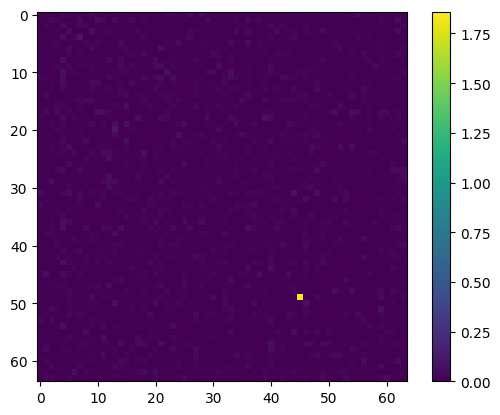

In [10]:
b= np.random.randint(0,100)
plt.imshow(images_np[b])
plt.colorbar()

In [65]:

# with h5py.File('/home/da886/ElectronCountingProject/final_combined_images_bboxes.h5', 'r') as hdf:
#     ls = list(hdf.keys())
#     images = hdf.get('images')
#     # boxes = hdf.get('boxes')
#     center_coordinates = hdf.get('center_coordinates')
#     images = np.array(images)
#     # boxes = np.array(boxes)
#     center_coordinates = np.array(center_coordinates)


In [6]:
center_coordinates

array([[[1.       , 0.8046875, 0.1640625],
        [1.       , 0.8515625, 0.2109375],
        [1.       , 0.1015625, 0.3046875],
        ...,
        [0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       ]],

       [[1.       , 0.4140625, 0.4140625],
        [1.       , 0.1015625, 0.4765625],
        [1.       , 0.0859375, 0.2109375],
        ...,
        [0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       ]],

       [[1.       , 0.0703125, 0.5859375],
        [1.       , 0.3359375, 0.3359375],
        [1.       , 0.7734375, 0.4140625],
        ...,
        [0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       ]],

       ...,

       [[1.       , 0.2109375, 0.2265625],
        [0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       ],
        ...,
        [0.       , 0.    

In [18]:

# image_normalized = (images + 1e-9) / 64
# # normalized_boxes = boxes / [1, 64, 64, 64, 64]

# images_np = image_normalized
# center_coordinates = center_coordinates / [1,64, 64]  # Normalizing the center coordinates
# probabilities = np.array(center_coordinates[:,:, :-2])
# probabilities = tf.expand_dims(probabilities, axis=1)
# center_coordinates_np = np.array(center_coordinates[:, :, 1:])
# center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)
# batch_size = 128
# dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# # dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
# total_items = len(images_np)
# train_size = int(total_items * 0.9)
# test_size = total_items - train_size 

#     # Splitting the dataset
# train_dataset = dataset.take(train_size)
# test_dataset = dataset.skip(train_size)


# train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
# train_dataset = train_dataset.batch(batch_size)
# test_dataset = test_dataset.batch(batch_size) 

2024-07-15 22:00:23.976879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 7, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c9:00.0, compute capability: 8.0


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

input_shape = (64, 64, 1)
num_classes = 12
num_coordinates = 2


x_input = layers.Input(shape=input_shape)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.4)(x) 

x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)

model = tf.keras.models.Model(x_input, [x_prob_reshape,x_midpoints_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 


In [17]:
# model = tf.keras.models.load_model("/home/da886/ElectronCountingProject/Weights from my data/weights for 1 layer 10 electron hits/1layer60000imagesmodelv2.keras")  ##### from Jingru's dataset

In [5]:
# from tensorflow.keras import layers, callbacks
# reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=3e-11, verbose=1)

In [10]:
@tf.keras.utils.register_keras_serializable()
class MaskedMeanSquaredError(tf.keras.losses.Loss):
    def __init__(self, name="masked_mse_loss", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # Create mask
        mask = tf.reduce_sum(y_true, axis=-1) > 0
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, axis=-1)

        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate mean squared error
        mse = tf.reduce_mean(tf.square(y_true_masked - y_pred_masked), axis=-1)

        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(mse) / mask_sum
        return masked_loss


@tf.keras.utils.register_keras_serializable()
class MaskedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, name="masked_binary_crossentropy", **kwargs):
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        # Create mask
        mask = tf.reduce_sum(y_true, axis=-1) > 0
        mask = tf.cast(mask, tf.float32)
        mask = tf.expand_dims(mask, axis=-1)

        # Apply mask to the true and predicted values
        y_true_masked = y_true * mask
        y_pred_masked = y_pred * mask

        # Calculate binary cross-entropy
        bce = tf.keras.losses.binary_crossentropy(y_true_masked, y_pred_masked)

        # Normalize the loss by the number of non-zero elements in the mask
        mask_sum = tf.reduce_sum(mask)
        masked_loss = tf.reduce_sum(bce) / mask_sum
        return masked_loss
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': MaskedBinaryCrossentropy(), 'x_midpoints_reshape':MaskedMeanSquaredError()})   
# num_epochs = 1000

In [28]:
from tensorflow.keras import layers, callbacks
# Custom callback to save the model every 10 epochs
class CustomModelCheckpoint(callbacks.Callback):
    def __init__(self, save_freq, save_path):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.save_path.format(epoch=epoch + 1))
            print(f"Model saved at epoch {epoch + 1}")

save_freq = 10  # Save every 10 epochs
save_path = "/home/da886/ElectronCountingProject/Weights from my data/weights for 2 layers 10 electrons with regularizer/modelv3_epoch_{epoch:02d}.h5"
checkpoint_callback = CustomModelCheckpoint(save_freq=save_freq, save_path=save_path)

In [29]:
model.fit(dataset,epochs =100,callbacks=[checkpoint_callback])

Epoch 1/100


2024-07-18 19:15:22.340551: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[400,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[400,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-07-18 19:15:25.583406: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.242956957s
Trying algorithm eng0{} for conv (f32[400,512,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[400,512,32,32]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_

150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 88ms/step - loss: 0.0626
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.0629
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0628
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0629
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0627
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0627
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0626
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 0.0627
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0631
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0628

Model saved at epoch 10
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0628
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.0627
Epoch 12/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0626
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - loss: 0.0627
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - loss: 0.0629
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - loss: 0.0628
Epoch 16/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - loss: 0.0627
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0625
Epoch 18/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - loss: 0.0629
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0627
Epoch 20/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0628

Model saved at epoch 20
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0628
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0624
Epoch 22/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0628
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.0626
Epoch 24/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0627
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0627
Epoch 26/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0629
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 0.0626
Epoch 28/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0624
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0625
Epoch 30/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0624

Model saved at epoch 30
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0624
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - loss: 0.0627
Epoch 32/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0625
Epoch 33/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0625
Epoch 34/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0622
Epoch 35/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0624
Epoch 36/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.0626
Epoch 37/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0624
Epoch 38/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0623
Epoch 39/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0625
Epoch 40/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0622

Model saved at epoch 40
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0622
Epoch 41/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.0624
Epoch 42/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0623
Epoch 43/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0624
Epoch 44/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0624
Epoch 45/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0626
Epoch 46/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0624
Epoch 47/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0624
Epoch 48/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 0.0622
Epoch 49/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0622
Epoch 50/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0623

Model saved at epoch 50
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0623
Epoch 51/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - loss: 0.0623
Epoch 52/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - loss: 0.0622
Epoch 53/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - loss: 0.0621
Epoch 54/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - loss: 0.0621
Epoch 55/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0622
Epoch 56/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - loss: 0.0624
Epoch 57/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0621
Epoch 58/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - loss: 0.0625
Epoch 59/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.0624
Epoch 60/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0622

Model saved at epoch 60
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0622
Epoch 61/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0621
Epoch 62/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0622
Epoch 63/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0622
Epoch 64/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.0622
Epoch 65/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0621
Epoch 66/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0621
Epoch 67/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.0620
Epoch 68/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0621
Epoch 69/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0626
Epoch 70/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0625

Model saved at epoch 70
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0625
Epoch 71/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0623
Epoch 72/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0621
Epoch 73/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0624
Epoch 74/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0623
Epoch 75/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0619
Epoch 76/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0624
Epoch 77/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0624
Epoch 78/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0623
Epoch 79/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0623
Epoch 80/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0624

Model saved at epoch 80
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0624
Epoch 81/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0625
Epoch 82/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.0624
Epoch 83/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 0.0625
Epoch 84/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0620
Epoch 85/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.0619
Epoch 86/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.0621
Epoch 87/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0623
Epoch 88/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 0.0625
Epoch 89/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.0619
Epoch 90/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0619

Model saved at epoch 90
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - loss: 0.0619
Epoch 91/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0622
Epoch 92/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0623
Epoch 93/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0620
Epoch 94/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0621
Epoch 95/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0624
Epoch 96/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0621
Epoch 97/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0622
Epoch 98/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0621
Epoch 99/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0622
Epoch 100/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0620

Model saved at epoch 100
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.0620


In [32]:
model.save("/home/da886/ElectronCountingProject/Weights from my data/weights for 1 layer 10 electron hits/1layer60000imagesmodelv4.h5")  ##### Jingrui's
# model = tf.keras.models.load_model("/home/da886/ElectronCountingProject/Weights from my data/weights for 1 layer 10 electron hits/1layer60000imagesmodelv4.keras") 

In [33]:
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# test_dataset = dataset.take(train_size)
dataset = dataset.batch(400)
inputs,targets = next(iter(dataset))
# inputs,targets = next(iter(test_dataset))
output =model.predict(inputs)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [9]:
n = model.evaluate(dataset)

KeyboardInterrupt: 

In [34]:
import tensorflow as tf

# r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_midpoints_reshape'], dtype=tf.float64)

tensor2 = tf.constant(output[1], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = MaskedMeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())

MSE Loss: 0.05515875


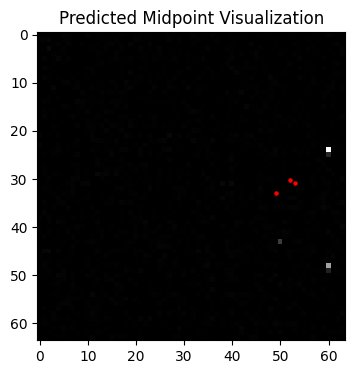

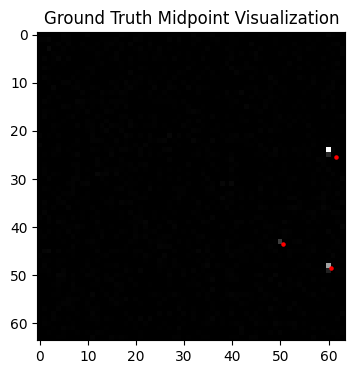

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Predicted Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(y, x, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()
    
    

t = np.random.randint(0,450)
# t=1
visualize_midpoints(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction   

def visualize_midpoints2(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Ground Truth Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(y, x, color='red', s=5)
            # if i == 0:  # Add label only once to avoid repetition in the legend
            #     plt.legend()

    plt.show()     
visualize_midpoints2(tf.convert_to_tensor(images[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64]) ##ground truth          




In [102]:
import numpy as np

def evaluate_model(predictions, ground_truths, probability_threshold=0.9, midpoint_diff_threshold=0.05):
    pred_probabilities = predictions[0]
    pred_midpoints = predictions[1]
    gt_probabilities = ground_truths[0]
    gt_midpoints = ground_truths[1]
    
    # Valid predictions are those above the probability threshold
    valid_predictions = pred_probabilities > probability_threshold
    no_predictions = pred_probabilities <= probability_threshold

    # Calculate differences for midpoint evaluations
    midpoint_diff = np.abs(pred_midpoints - gt_midpoints)
    is_accurate_prediction = np.all(midpoint_diff <= midpoint_diff_threshold, axis=1)
    
    # True Positives: Valid predictions close enough to the ground truth
    TP = np.sum(np.logical_and(valid_predictions, is_accurate_prediction))
    
    # False Positives: Valid predictions not close enough to the ground truth
    FP = np.sum(np.logical_and(valid_predictions, ~is_accurate_prediction))
    
    # True Negatives: No predictions where no objects are actually present
    TN = np.sum(np.logical_and(no_predictions, gt_probabilities <= probability_threshold))
    
    # False Negatives: No predictions where objects are actually present
    FN = np.sum(np.logical_and(no_predictions, gt_probabilities > probability_threshold))
    
    # Metrics calculation
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    MAE = np.mean(midpoint_diff)
    MSE = np.mean(np.square(midpoint_diff))
    
    return precision, recall, F1_score, MAE, MSE

# Usage 
predictions = [output[0][0:800], output[1][0:800]]
ground_truths = [targets['x_prob_reshape'][0:800], targets['x_midpoints_reshape'][0:800]]
precision, recall, F1_score, MAE, MSE = evaluate_model(predictions, ground_truths)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {F1_score}, MAE: {MAE}, MSE: {MSE}")


Precision: 0.5161742092761595, Recall: 1.0, F1 Score: 0.6808903701410244, MAE: 0.2807062132781524, MSE: 0.15852413947898508


In [103]:
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min
import tensorflow as tf  # Assuming TensorFlow is used for tensor conversion

def pos_deviation(coords, truth):
    """
    Calculate the distances between detected electron incident positions and the ground truth positions in units of pixels.
    """
    distances = []
    if len(coords) > 0:
        assignment, distances = pairwise_distances_argmin_min(coords, truth)
    return distances

def end2end_evaluation(groundtruth, predicted, tolerance):
    """
    Evaluate the model performance in detecting electron incident positions.

    Args:
    groundtruth: numpy array or TensorFlow tensor of ground truth electron positions.
    predicted: numpy array or TensorFlow tensor of predicted electron positions.
    tolerance: predictions with position error no larger than "tolerance" pixels will be selected as true positive.

    Returns:
    recall: recall of the prediction
    precision: precision of the prediction
    f1: F1 score
    dce: detector conversion efficiency (ratio of detected electrons to ground truth electrons)
    mae_position: mean position error (Euclidean distance) averaged over all detected electrons
    """

    # Convert TensorFlow tensors to NumPy arrays if necessary
    if isinstance(groundtruth, tf.Tensor):
        groundtruth = groundtruth.numpy()
    if isinstance(predicted, tf.Tensor):
        predicted = predicted.numpy()

    # Flatten the coordinates for comparison
    groundtruth_coords = groundtruth.reshape(-1, 2)
    predicted_coords = predicted.reshape(-1, 2)

    # Calculate the real total number of ground truth electrons
    num_groundtruth_electrons = len(groundtruth_coords)

    # Calculate the deviations between the predicted and ground truth positions
    deviations = pos_deviation(predicted_coords, groundtruth_coords)

    # Get the true positives, which have an error no larger than "tolerance" pixels
    true_positives = np.sum(deviations <= tolerance)

    # Calculate precision
    precision = true_positives / len(predicted_coords) if len(predicted_coords) > 0 else 0

    # Calculate recall
    recall = true_positives / num_groundtruth_electrons if num_groundtruth_electrons > 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate detector conversion efficiency
    dce = len(predicted_coords) / num_groundtruth_electrons if num_groundtruth_electrons > 0 else 0

    # Calculate mean absolute error of positions
    mae_position = deviations.mean() if len(deviations) > 0 else 0

    # Print and return the evaluation metrics
    print('Recall:', recall, 'Precision:', precision, 'F1:', f1, 'DCE:', dce, 'MAE of positions:', mae_position)
    return recall, precision, f1, dce, mae_position


In [104]:

evaluation = end2end_evaluation(targets['x_midpoints_reshape'][0:600], output[1][0:600],0.05)

Recall: 1.0 Precision: 1.0 F1: 1.0 DCE: 1.0 MAE of positions: 0.008038402247415836


: 